In [13]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from PIL import Image
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Dataset

In [2]:
path = os.getcwd()
save_path = os.path.join(path,"save")

In [3]:
# 데이터 로딩 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): csv 파일의 경로.
            transform (callable, optional): 샘플에 적용될 Optional transform.
        """
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df['img_path'].iloc[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 이미지 전처리 및 임베딩
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

train_data = CustomDataset(csv_file=os.path.join(path,"train.csv"), transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=False)

In [5]:
# CNN 기반 Autoencoder 모델 정의
class AutoencoderCNN(nn.Module):
    def __init__(self):
        super(AutoencoderCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.3),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.3),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.3),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.3),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.3),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.3),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.3),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
model = AutoencoderCNN().to(device)

# 손실 함수 및 최적화 기준 설정
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 모델 학습
num_epochs = 1000
for epoch in range(num_epochs):
    running_loss = 0.0
    for data in train_loader:
        images = data
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader.dataset)}")

Epoch [1/1000], Loss: 1.0311933800648077
Epoch [2/1000], Loss: 1.0271518264018313
Epoch [3/1000], Loss: 1.0225399206501777
Epoch [4/1000], Loss: 1.0158993201636373
Epoch [5/1000], Loss: 1.0028462225282695
Epoch [6/1000], Loss: 0.9721454605809959
Epoch [7/1000], Loss: 0.9070409863767489
Epoch [8/1000], Loss: 0.8149363082339506
Epoch [9/1000], Loss: 0.7226637126134595
Epoch [10/1000], Loss: 0.625792770038748
Epoch [11/1000], Loss: 0.5331505735715231
Epoch [12/1000], Loss: 0.4660508866321313
Epoch [13/1000], Loss: 0.4199499138084376
Epoch [14/1000], Loss: 0.38949322924367696
Epoch [15/1000], Loss: 0.37216635699003514
Epoch [16/1000], Loss: 0.36018472448201244
Epoch [17/1000], Loss: 0.3513615720428771
Epoch [18/1000], Loss: 0.34482081633218575
Epoch [19/1000], Loss: 0.3395968366396819
Epoch [20/1000], Loss: 0.3347886729408318
Epoch [21/1000], Loss: 0.33028138481395347
Epoch [22/1000], Loss: 0.32583036081331995
Epoch [23/1000], Loss: 0.32150621705211946
Epoch [24/1000], Loss: 0.316755215047

Epoch [191/1000], Loss: 0.10522210842846705
Epoch [192/1000], Loss: 0.10513577120544765
Epoch [193/1000], Loss: 0.1050623668961122
Epoch [194/1000], Loss: 0.1049872682967656
Epoch [195/1000], Loss: 0.10489896072748121
Epoch [196/1000], Loss: 0.10482225682533963
Epoch [197/1000], Loss: 0.10472684675399127
Epoch [198/1000], Loss: 0.10464286192062315
Epoch [199/1000], Loss: 0.10455075794822173
Epoch [200/1000], Loss: 0.10448661159741486
Epoch [201/1000], Loss: 0.1044218918667153
Epoch [202/1000], Loss: 0.10435044496132174
Epoch [203/1000], Loss: 0.10425862264185444
Epoch [204/1000], Loss: 0.10419919866491371
Epoch [205/1000], Loss: 0.10413673152806054
Epoch [206/1000], Loss: 0.10404927164596012
Epoch [207/1000], Loss: 0.10395429601691698
Epoch [208/1000], Loss: 0.1039096818703441
Epoch [209/1000], Loss: 0.10383771965061554
Epoch [210/1000], Loss: 0.1038168372472687
Epoch [211/1000], Loss: 0.1037092442873498
Epoch [212/1000], Loss: 0.10366091905205463
Epoch [213/1000], Loss: 0.103585402940

Epoch [378/1000], Loss: 0.09781985033845678
Epoch [379/1000], Loss: 0.097774556580004
Epoch [380/1000], Loss: 0.09776627457757511
Epoch [381/1000], Loss: 0.09775823410687871
Epoch [382/1000], Loss: 0.09772451869059057
Epoch [383/1000], Loss: 0.09771347273263573
Epoch [384/1000], Loss: 0.0976740665419001
Epoch [385/1000], Loss: 0.09764856586293995
Epoch [386/1000], Loss: 0.0976455259560979
Epoch [387/1000], Loss: 0.09760989556570009
Epoch [388/1000], Loss: 0.09758670960373722
Epoch [389/1000], Loss: 0.09756113106096295
Epoch [390/1000], Loss: 0.0975340369371741
Epoch [391/1000], Loss: 0.09753773120087637
Epoch [392/1000], Loss: 0.0975046608369675
Epoch [393/1000], Loss: 0.0974807545822551
Epoch [394/1000], Loss: 0.09746126659179517
Epoch [395/1000], Loss: 0.09745092077854094
Epoch [396/1000], Loss: 0.09742317527112826
Epoch [397/1000], Loss: 0.09739760260486827
Epoch [398/1000], Loss: 0.09739093311096021
Epoch [399/1000], Loss: 0.09735059286926834
Epoch [400/1000], Loss: 0.0973230535645

Epoch [566/1000], Loss: 0.09496307649382962
Epoch [567/1000], Loss: 0.09496580938778013
Epoch [568/1000], Loss: 0.0949432147150868
Epoch [569/1000], Loss: 0.09494562380610497
Epoch [570/1000], Loss: 0.09492340995252413
Epoch [571/1000], Loss: 0.09489982648634575
Epoch [572/1000], Loss: 0.09491207650010015
Epoch [573/1000], Loss: 0.09488221779115882
Epoch [574/1000], Loss: 0.09487409567888913
Epoch [575/1000], Loss: 0.09487861492824107
Epoch [576/1000], Loss: 0.09485935612183781
Epoch [577/1000], Loss: 0.09485781549567908
Epoch [578/1000], Loss: 0.09484562113391401
Epoch [579/1000], Loss: 0.09483008649847317
Epoch [580/1000], Loss: 0.09482722040353246
Epoch [581/1000], Loss: 0.0948265691948049
Epoch [582/1000], Loss: 0.0948142139634616
Epoch [583/1000], Loss: 0.09479695390647566
Epoch [584/1000], Loss: 0.09478466786409208
Epoch [585/1000], Loss: 0.09477756329825227
Epoch [586/1000], Loss: 0.09476261243154185
Epoch [587/1000], Loss: 0.09474810377253054
Epoch [588/1000], Loss: 0.094741488

Epoch [753/1000], Loss: 0.09344514592292723
Epoch [754/1000], Loss: 0.09343547552404269
Epoch [755/1000], Loss: 0.09342770404379133
Epoch [756/1000], Loss: 0.09341464079741581
Epoch [757/1000], Loss: 0.09341945422227393
Epoch [758/1000], Loss: 0.0934181529591341
Epoch [759/1000], Loss: 0.09339876395995628
Epoch [760/1000], Loss: 0.09339782105924938
Epoch [761/1000], Loss: 0.09338039436110868
Epoch [762/1000], Loss: 0.09338486019714337
Epoch [763/1000], Loss: 0.09337968606624245
Epoch [764/1000], Loss: 0.09336859613936832
Epoch [765/1000], Loss: 0.09335860749925247
Epoch [766/1000], Loss: 0.09335002666907691
Epoch [767/1000], Loss: 0.0933437521958575
Epoch [768/1000], Loss: 0.09333945457504389
Epoch [769/1000], Loss: 0.09333297145058851
Epoch [770/1000], Loss: 0.09332407818573742
Epoch [771/1000], Loss: 0.09332489760968607
Epoch [772/1000], Loss: 0.09330262981809921
Epoch [773/1000], Loss: 0.093302400004416
Epoch [774/1000], Loss: 0.09328923636758832
Epoch [775/1000], Loss: 0.0932966787

Epoch [940/1000], Loss: 0.09228344090247938
Epoch [941/1000], Loss: 0.09227820790149796
Epoch [942/1000], Loss: 0.09226560917958407
Epoch [943/1000], Loss: 0.09226038492341557
Epoch [944/1000], Loss: 0.09225390270842074
Epoch [945/1000], Loss: 0.09226295701774632
Epoch [946/1000], Loss: 0.09224163184703237
Epoch [947/1000], Loss: 0.09224537973392738
Epoch [948/1000], Loss: 0.09224519605787707
Epoch [949/1000], Loss: 0.0922285075268835
Epoch [950/1000], Loss: 0.09221442585959681
Epoch [951/1000], Loss: 0.09222040332399063
Epoch [952/1000], Loss: 0.09221870672534889
Epoch [953/1000], Loss: 0.09220759063399454
Epoch [954/1000], Loss: 0.09219876225565521
Epoch [955/1000], Loss: 0.09219603716207782
Epoch [956/1000], Loss: 0.09219369596578705
Epoch [957/1000], Loss: 0.09219597384963236
Epoch [958/1000], Loss: 0.09218983642512084
Epoch [959/1000], Loss: 0.09218798301449405
Epoch [960/1000], Loss: 0.09216982829318919
Epoch [961/1000], Loss: 0.09216336689084909
Epoch [962/1000], Loss: 0.0921576

In [7]:
train_loss = running_loss/len(train_loader.dataset)
print(train_loss)

0.09196431007883359


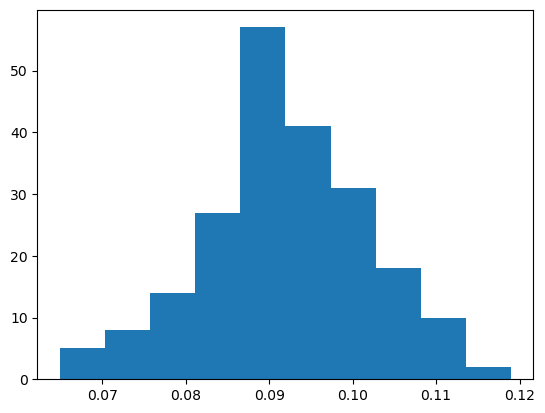

0.09197786908614243
0.10191939920186996


In [32]:
train_dataset2 = CustomDataset(csv_file=os.path.join(path,"train.csv"), transform=transform)
train_loader2 = DataLoader(train_dataset2, shuffle=False)

correct = 0
total = 0
test_pred = []
loss_list = []
with torch.no_grad():
    for data in train_loader2:
        images = data
        images = images.to(device)
        outputs = model(images)
        loss = criterion(outputs, images).to(device).item()
        loss_list.append(loss)
# print(loss_list)
plt.hist(loss_list)
plt.show()
print(np.mean(loss_list))
m = np.percentile(np.array(loss_list), 85, axis=0)
print(m)
            

In [26]:
test_dataset = CustomDataset(csv_file=os.path.join(path,"test.csv"), transform=transform)
test_loader = DataLoader(test_dataset, shuffle=False)

correct = 0
total = 0
test_pred = []
loss_list = []
with torch.no_grad():
    for data in test_loader:
        images = data
        images = images.to(device)
        outputs = model(images)
        loss = criterion(outputs, images).to(device).item()
        if loss<m:
            test_pred.append(0.)
        else:
            test_pred.append(1.)
            

[0.09494036436080933, 0.09021750092506409, 0.09522382915019989, 0.07970453798770905, 0.09743861854076385, 0.09085701406002045, 0.08526428043842316, 0.09715628623962402, 0.0939050242304802, 0.08118350803852081, 0.08283275365829468, 0.09513207525014877, 0.08408746123313904, 0.07825049757957458, 0.08459983766078949, 0.1046418696641922, 0.10116589069366455, 0.08166307210922241, 0.07822562754154205, 0.10628914088010788, 0.08736392110586166, 0.09182453155517578, 0.0882967934012413, 0.09682025760412216, 0.08850499987602234, 0.10574771463871002, 0.08322073519229889, 0.09922078251838684, 0.09739767014980316, 0.10259823501110077, 0.07045872509479523, 0.09012316167354584, 0.0819789320230484, 0.08676201105117798, 0.02165311574935913, 0.10523595660924911, 0.08870333433151245, 0.09011688828468323, 0.10032430291175842, 0.09237752854824066, 0.10403865575790405, 0.09890073537826538, 0.11020758002996445, 0.08360331505537033, 0.09677854180335999, 0.11360123008489609, 0.09207244962453842, 0.08599378168582

Text(50.722222222222214, 0.5, 'True Label')

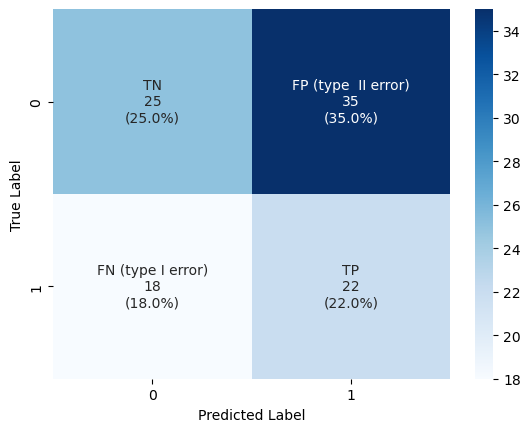

In [16]:
# answer = [0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,1,1,1,0,1,0,0,1,1,1,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,1,0,1,0,1,1,1,1,1,1,0,0,1,1]
# cf_matrix = confusion_matrix(answer, test_pred)
# group_names = ["TN", "FP (type  II error)", "FN (type I error)", "TP"]
# group_counts = [value for value in cf_matrix.flatten()]
# group_percentages = [f"{value:.1%}" for value in cf_matrix.flatten()/np.sum(cf_matrix)]
# labels = [f"{v1}\n{v2}\n({v3})" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

# labels = np.asarray(labels).reshape(2,2)
# labels
# sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')

In [17]:
submit = pd.read_csv(os.path.join(path,"sample_submission.csv"))
submit['label'] = test_pred
submit.head()

,id,label
0,TEST_000,1.0
1,TEST_001,0.0
2,TEST_002,1.0
3,TEST_003,0.0
4,TEST_004,1.0


In [18]:
submit.to_csv(os.path.join(save_path,"submit40.csv"), index=False)